In [5]:
from time import time
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

from collections import Counter
from nltk.corpus import stopwords

import nltk

## Parte 1: Cargado y Limpieza de datos

In [3]:
df_speeches = pd.read_csv('../data/us_2020_election_speeches.csv')
df_speeches

,speaker,title,text,date,location,type
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...","Oct 15, 2020",ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,"Oct 15, 2020",NBC,Town Hall
...,...,...,...,...,...,...
264,Bernie Sanders,Bernie Sanders Speech Transcript: Sanders Spea...,Bernie Sanders: (00:00)\nJust want to take thi...,"Feb 6, 2020",Iowa,Campaign Speech
265,Democratic Candidates,Transcript: Speeches at the Iowa Caucuses – Be...,Bernie Sanders: (00:08)\nThank you. Thank you....,"Feb 4, 2020",Iowa,Campaign Speech
266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,Donald Trump: (00:24)\nI worked so hard for th...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech
267,Donald Trump,Donald Trump New Jersey Rally Speech Transcrip...,Donald Trump: (01:22)\nThank you. Thank you. I...,"Jan 28, 2020","Wildwood, New Jersey",Campaign Speech


# A) Datos faltantes

Hacemos uso de las funciones len() y el atributo count() para obtener los datos faltantes por variable en el dataframe df_speeches

In [4]:
n = len(df_speeches)
count = df_speeches.count()
n-count

speaker      3
title        0
text         0
date         0
location    18
type        21
dtype: int64

In [10]:
# select numerical columns
df_speeches.dtypes

speaker     object
title       object
text        object
date        object
location    object
type        object
dtype: object

In [11]:
def get_var_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name, ": ", get_var_category(df[column_name]))

print_categories(df_speeches)

speaker :  Categorical
title :  Text (Unique)
text :  Text (Unique)
date :  Categorical
location :  Categorical
type :  Categorical


In [12]:
df_speeches.describe()

,speaker,title,text,date,location,type
count,266,269,269,269,251,248
unique,71,269,269,123,102,9
top,Joe Biden,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,"Aug 20, 2020",Virtual,Campaign Speech
freq,71,1,1,9,62,180


In [13]:
# how many types and obs are?
df_speeches["type"].value_counts()

type
Campaign Speech       180
Town Hall              18
Interview              14
Debate                  9
Endorsement             8
Statement               8
Roundtable              8
Press Conference        2
Voter Mobilization      1
Name: count, dtype: int64

In [14]:
# filter campaign speeches
speeches = df_speeches[df_speeches["type"] == "Campaign Speech"]


In [15]:
# group speeches by speaker
speeches["speaker"].value_counts()


speaker
Joe Biden                   43
Donald Trump                41
Mike Pence                  17
Bernie Sanders               9
Kamala Harris                7
Multiple Speakers            5
Democratic Candidates        4
Jill Biden                   2
Pete Buttigieg               2
David Perdue                 1
Gavin Newsom                 1
Elizabeth Warren             1
Barack Obama                 1
Andrew Yang                  1
Michael Bloomberg            1
Cory Booker                  1
Sarah Cooper                 1
Nancy Pelosi                 1
Hillary Clinton              1
Bill Clinton                 1
Cindy McCain                 1
Colin Powell                 1
Alexandria Ocasio-Cortez     1
Nikki Haley                  1
Chuck Schumer                1
Michelle Obama               1
John Kasich                  1
Andrew Cuomo                 1
Gretchen Whitmer             1
Joe Biden, Barack Obama      1
Kanye West                   1
Jim Jordan                   1


In [16]:
top5_speakers = speeches["speaker"].value_counts().head(5).index

top_speeches = speeches[speeches["speaker"].isin(top5_speakers)]


# B) Gráfica para visualizar discursos de los candidatos por año

/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/3507560894.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_speeches["CleanText"] = clean_text(top_speeches, "text")
/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/3507560894.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_speeches["date"] = pd.to_datetime(top_speeches["date"], errors="coerce")
/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/3507560894.py:29: SettingWithCopyWarning: 
A value is 

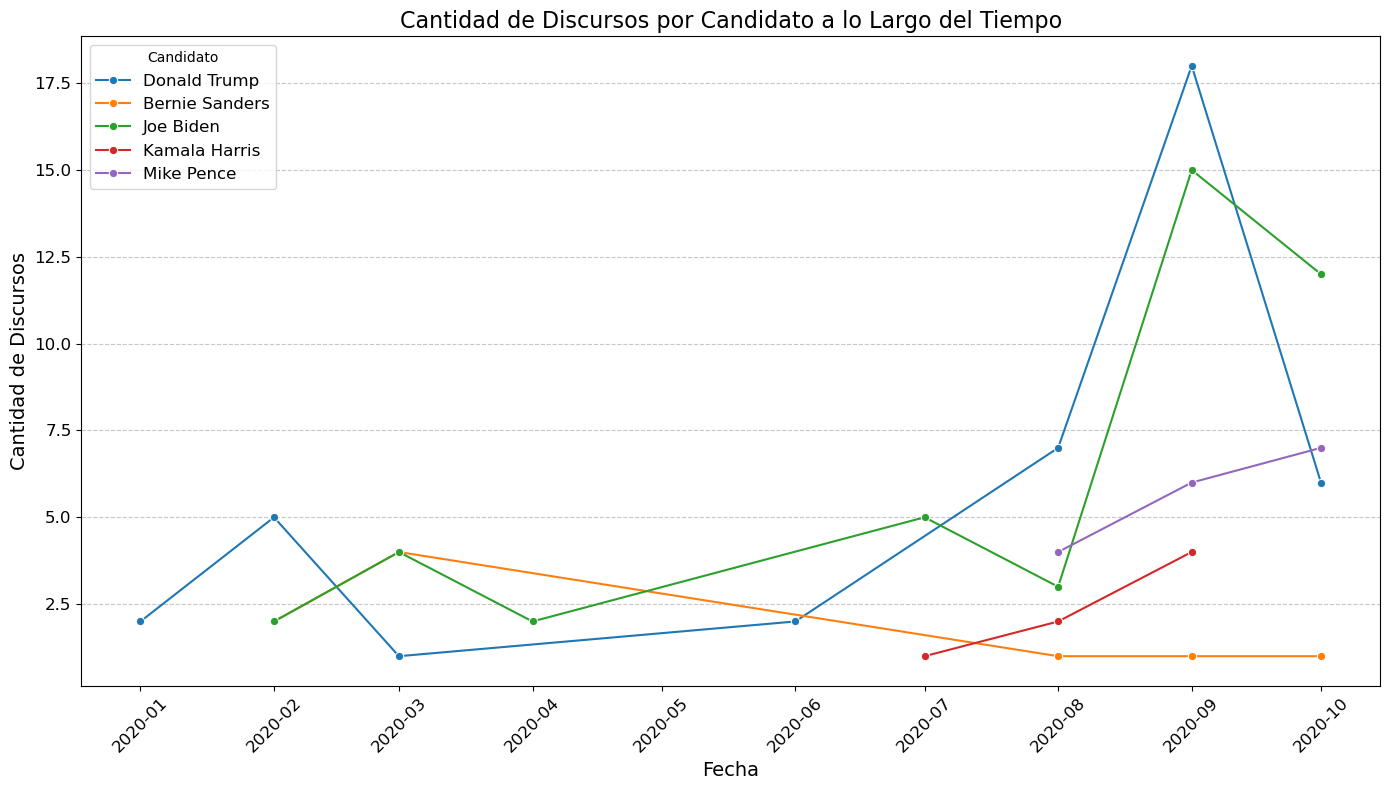

In [17]:
def clean_text(df, column_name):
    # Eliminar primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"^[^\n]*\n", "", regex=True)
    
    # Convertir todo a minúsculas
    result = result.str.lower()
    
    # Eliminar signos de puntuación y caracteres no deseados
    for punc in ["[", "]", "\n", ",", ":", "?", ".", "!", ";", "\"", "\'"]:
        result = result.str.replace(punc, " ", regex=False)
    
    # Eliminar espacios extra
    result = result.str.replace(r"\s+", " ", regex=True).str.strip()
    
    return result

# Crear la columna CleanText
top_speeches["CleanText"] = clean_text(top_speeches, "text")


# Asegurarse de que la columna 'date' esté en formato datetime
top_speeches["date"] = pd.to_datetime(top_speeches["date"], errors="coerce")

# Verificar si hay valores nulos después de la conversión
if top_speeches["date"].isnull().any():
    print("Advertencia: Hay valores nulos en la columna 'date' después de la conversión.")

# Agrupar por mes para reducir la cantidad de puntos en el eje X
top_speeches["month"] = top_speeches["date"].dt.to_period("M")
top_speeches_grouped = top_speeches.groupby(["month", "speaker"]).size().reset_index(name="count")

# Convertir el período a una fecha para el gráfico
top_speeches_grouped["month"] = top_speeches_grouped["month"].dt.to_timestamp()

# Crear la visualización
plt.figure(figsize=(14, 8))
sns.lineplot(data=top_speeches_grouped, x="month", y="count", hue="speaker", marker="o")
plt.title("Cantidad de Discursos por Candidato a lo Largo del Tiempo", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Cantidad de Discursos", fontsize=14)
plt.legend(title="Candidato", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

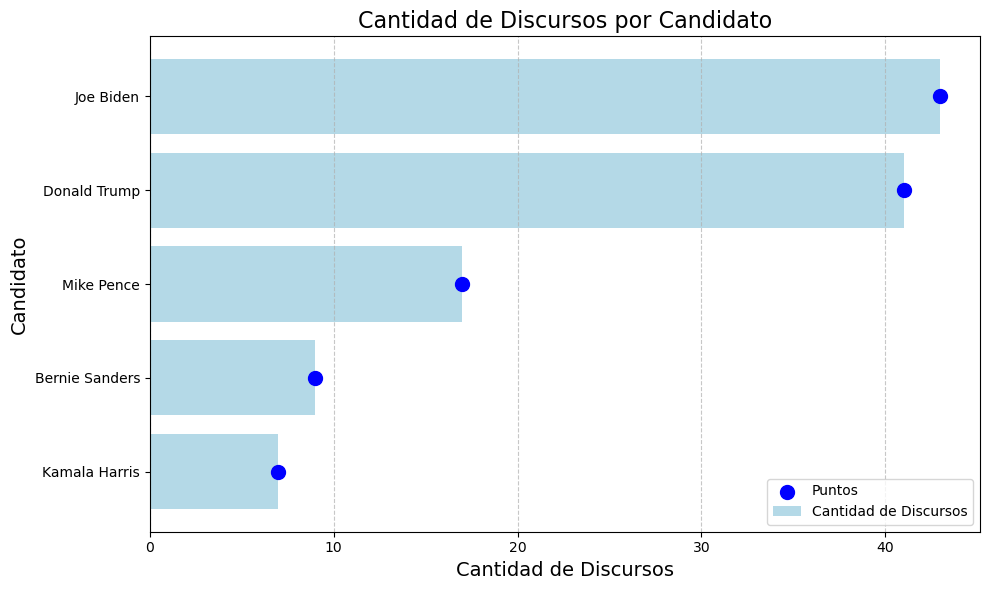

In [18]:
# Agrupar los datos por candidato y contar la cantidad de discursos
lollipop_data = top_speeches.groupby("speaker").size().reset_index(name="count")

# Ordenar los datos por la cantidad de discursos
lollipop_data = lollipop_data.sort_values(by="count", ascending=False)

# Crear el gráfico de lollipop
plt.figure(figsize=(10, 6))
sns.barplot(data=lollipop_data, x="count", y="speaker", color="skyblue", alpha=0.7, label="Cantidad de Discursos")
plt.scatter(lollipop_data["count"], lollipop_data["speaker"], color="blue", s=100, label="Puntos")

# Personalizar el gráfico
plt.title("Cantidad de Discursos por Candidato", fontsize=16)
plt.xlabel("Cantidad de Discursos", fontsize=14)
plt.ylabel("Candidato", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1679564151.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_speeches["date"] = pd.to_datetime(top_speeches["date"], errors="coerce")
/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1679564151.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_speeches["quarter"] = top_speeches["date"].dt.to_period("Q").dt.to_timestamp()
/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1679564151.py:20: SettingWithCopyW

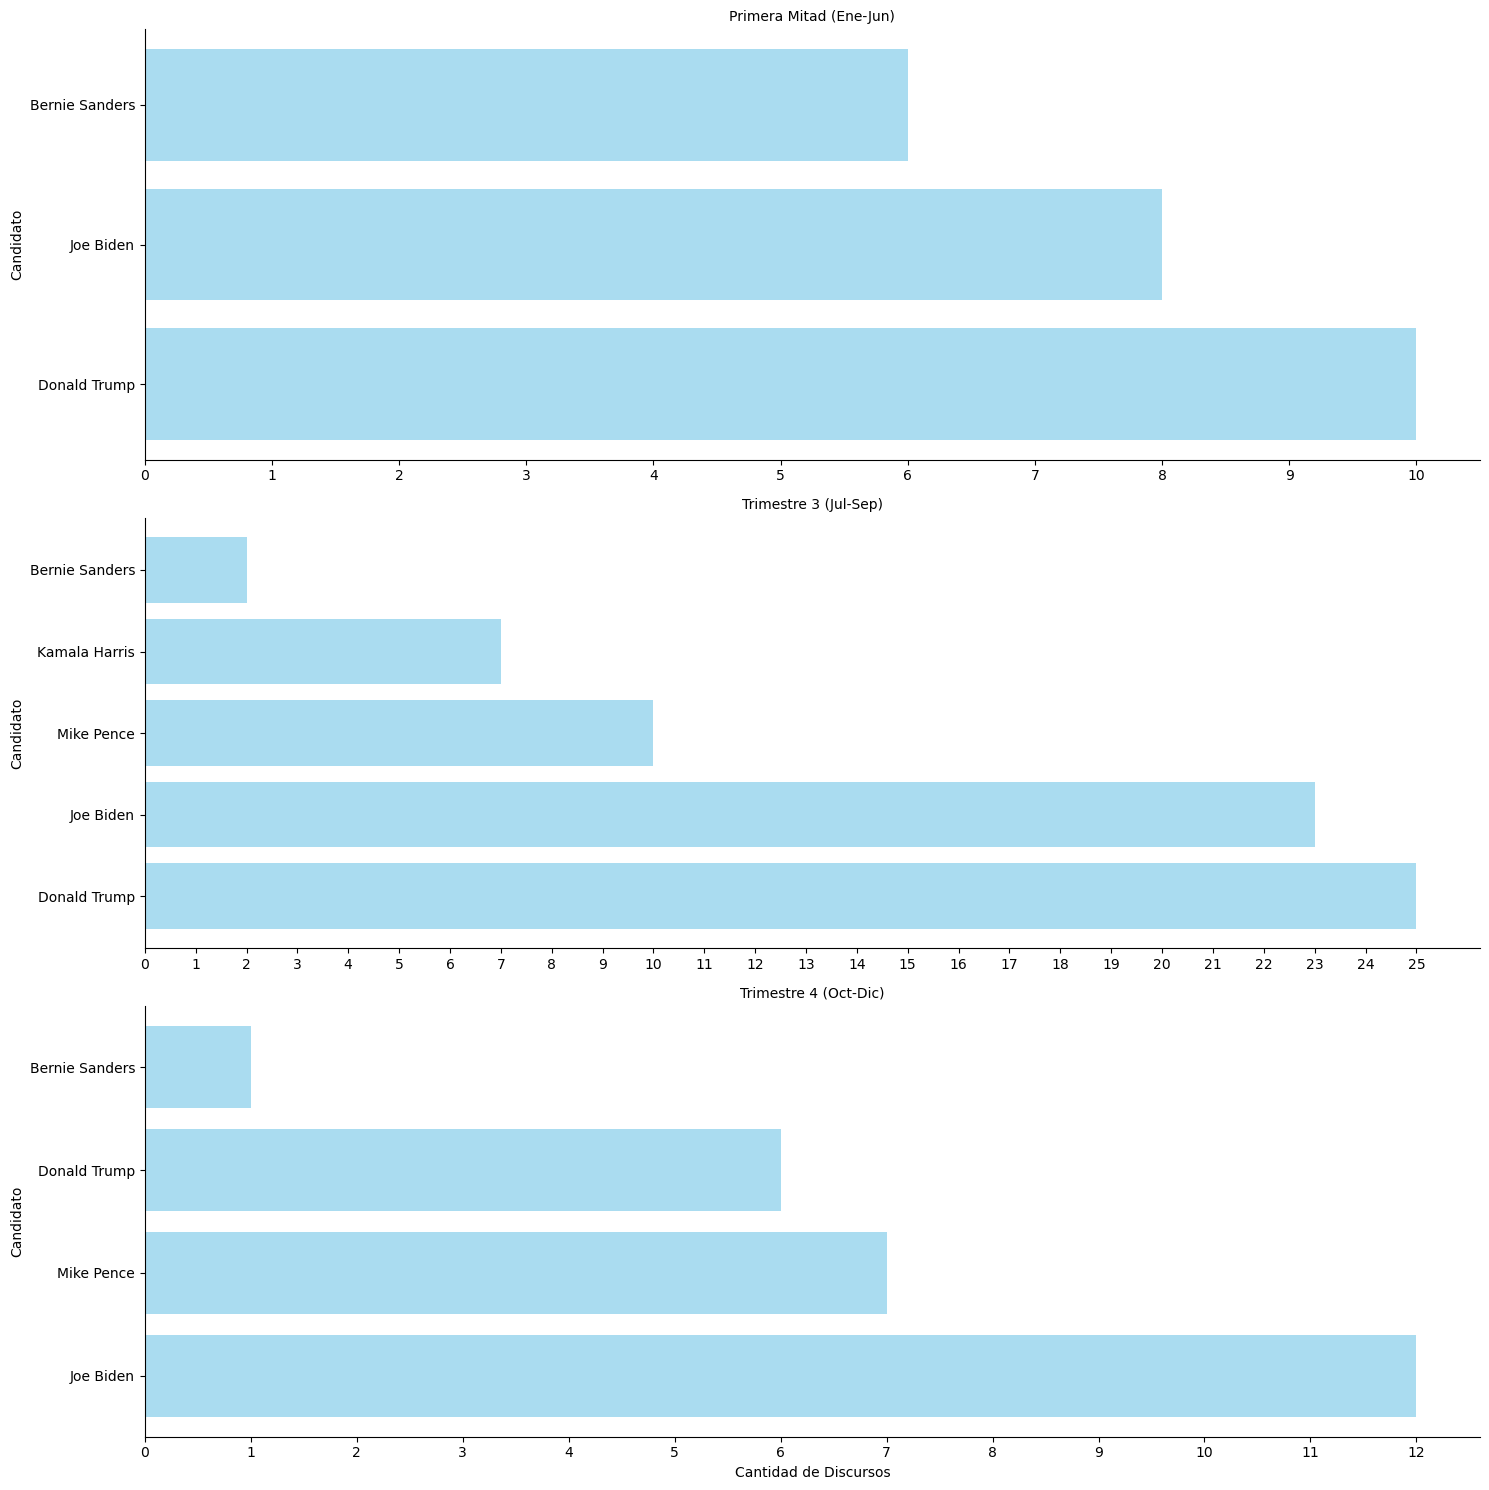

In [ ]:


# Asegurarse de que la columna 'date' esté en formato datetime
top_speeches["date"] = pd.to_datetime(top_speeches["date"], errors="coerce")

# Agrupar los datos por trimestre y candidato, y contar la cantidad de discursos
top_speeches["quarter"] = top_speeches["date"].dt.to_period("Q").dt.to_timestamp()

# Crear una nueva columna para agrupar el primer y segundo trimestre
def group_quarters(quarter):
    if quarter.month in [1, 2, 3, 4, 5, 6]:  # Trimestres 1 y 2
        return "Primera Mitad (Ene-Jun)"
    elif quarter.month in [7, 8, 9]:  # Trimestre 3
        return "Trimestre 3 (Jul-Sep)"
    else:  # Trimestre 4
        return "Trimestre 4 (Oct-Dic)"

top_speeches["grouped_quarter"] = top_speeches["quarter"].apply(group_quarters)

# Agrupar los datos por la nueva columna y candidato, y contar la cantidad de discursos
facet_data = top_speeches.groupby(["grouped_quarter", "speaker"]).size().reset_index(name="count")

# Ordenar los datos por frecuencia dentro de cada grupo
facet_data = facet_data.sort_values(by=["grouped_quarter", "count"], ascending=[True, False])

# Crear el FacetGrid con una faceta por fila y ajustar el ancho
g = sns.FacetGrid(facet_data, row="grouped_quarter", height=5, aspect=3, sharex=False, sharey=False)

# Agregar gráficos de lollipop a cada faceta (sin puntos)
def lollipop_plot(data, **kwargs):
    # Ordenar las barras por frecuencia
    data = data.sort_values(by="count", ascending=False)
    plt.barh(data["speaker"], data["count"], color="skyblue", alpha=0.7)
    # Ajustar la escala del eje X para que sea discreta
    max_count = data["count"].max()
    plt.xticks(np.arange(0, max_count + 1, 1))  # Escala discreta con pasos de 1

g.map_dataframe(lollipop_plot)

# Personalizar los títulos y las etiquetas
g.set_titles("{row_name}")
g.set_axis_labels("Cantidad de Discursos", "Candidato")
g.tight_layout()
plt.show()

# Parte C) Limpieza de texto

In [48]:
def clean_text(df, column_name):
    # Eliminar primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"^[^\n]*\n", "", regex=True)
    
    # Convertir todo a minúsculas
    result = result.str.lower()
    
    # Eliminar signos de puntuación y caracteres no deseados
    for punc in ["[", "]", "\n", ",", ":", "?", ".", "!", ";", "\"", "\'"]:
        result = result.str.replace(punc, " ", regex=False)
    
    # Eliminar espacios extra
    result = result.str.replace(r"\s+", " ", regex=True).str.strip()
    
    return result

# Crear la columna CleanText
top_speeches["CleanText"] = clean_text(top_speeches, "text")




/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1298669112.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mauroloprete/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1404019355.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sh/mgw2m9dj0zs38sv3l9p5h_780000gn/T/ipykernel_4713/1404019355.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



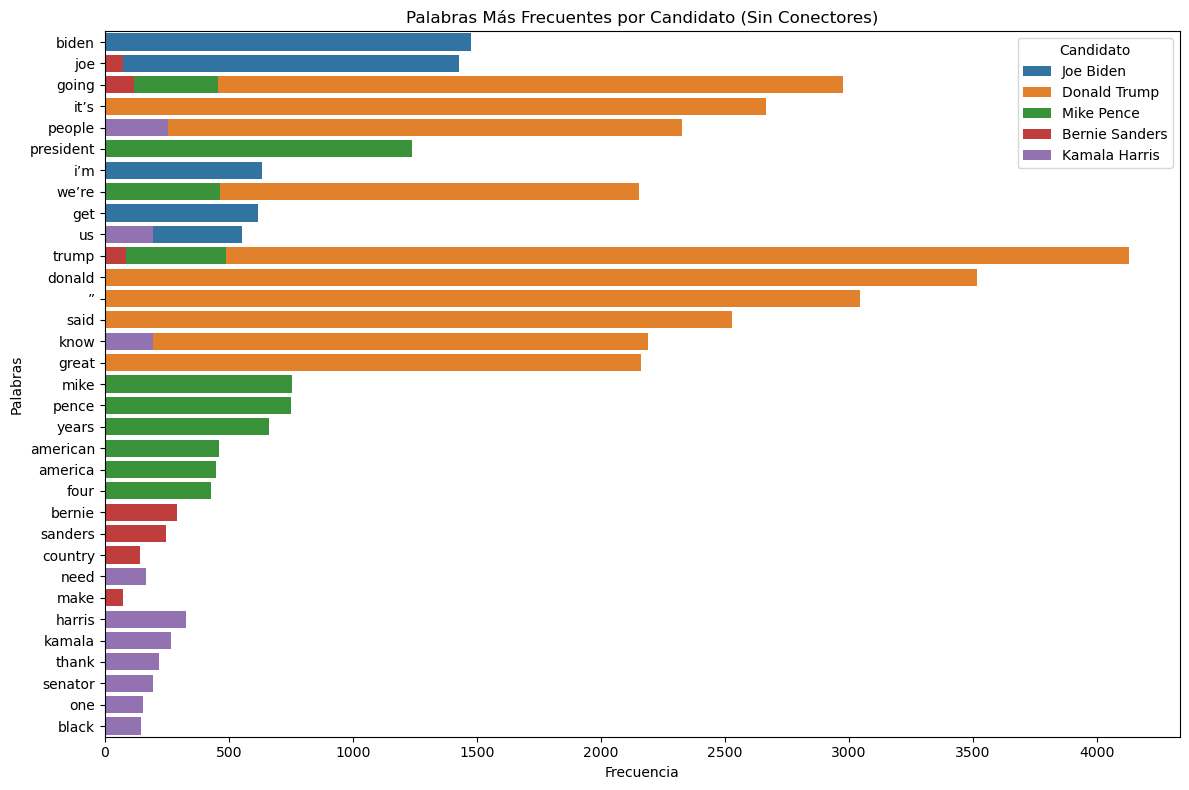

In [ ]:

# Descargar stopwords si es necesario
nltk.download('stopwords')

# Crear una lista de stopwords en inglés
stop_words = set(stopwords.words('english'))

# Crear la columna WordList si no existe
if "WordList" not in top_speeches.columns:
    top_speeches["WordList"] = top_speeches["CleanText"].str.split()

# Filtrar las palabras eliminando las stopwords
top_speeches["FilteredWordList"] = top_speeches["WordList"].apply(
    lambda words: [word for word in words if word not in stop_words]
)

# Contar palabras por candidato
word_counts = {}
for speaker in top_speeches["speaker"].unique():
    all_words = top_speeches[top_speeches["speaker"] == speaker]["FilteredWordList"].explode()
    word_counts[speaker] = Counter(all_words)

# Crear un DataFrame con las palabras más frecuentes
top_words = pd.DataFrame([
    {"speaker": speaker, "word": word, "count": count}
    for speaker, counts in word_counts.items()
    for word, count in counts.most_common(10)
])

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words, x="count", y="word", hue="speaker", dodge=False)
plt.title("Palabras Más Frecuentes por Candidato (Sin Conectores)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.legend(title="Candidato")
plt.tight_layout()
plt.show()

# TODO: Ordenar todo esto y redactar (Es de la parte 2)

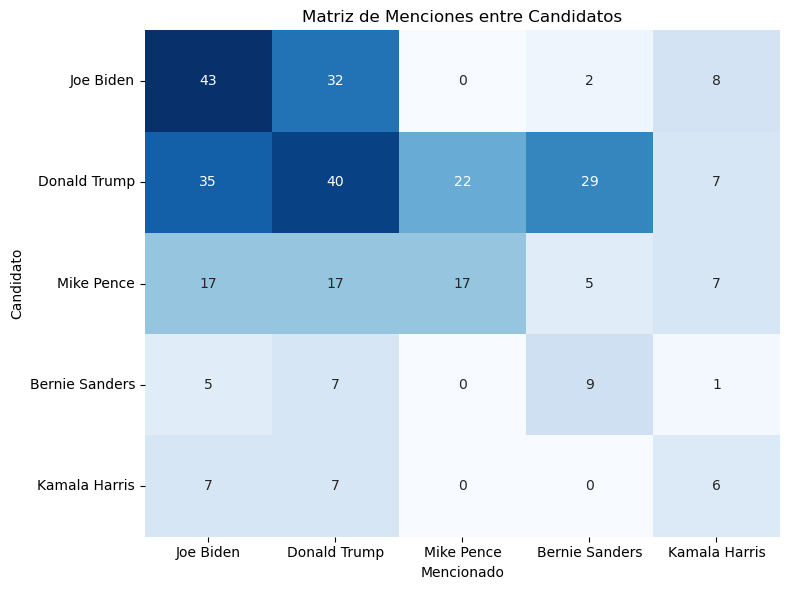

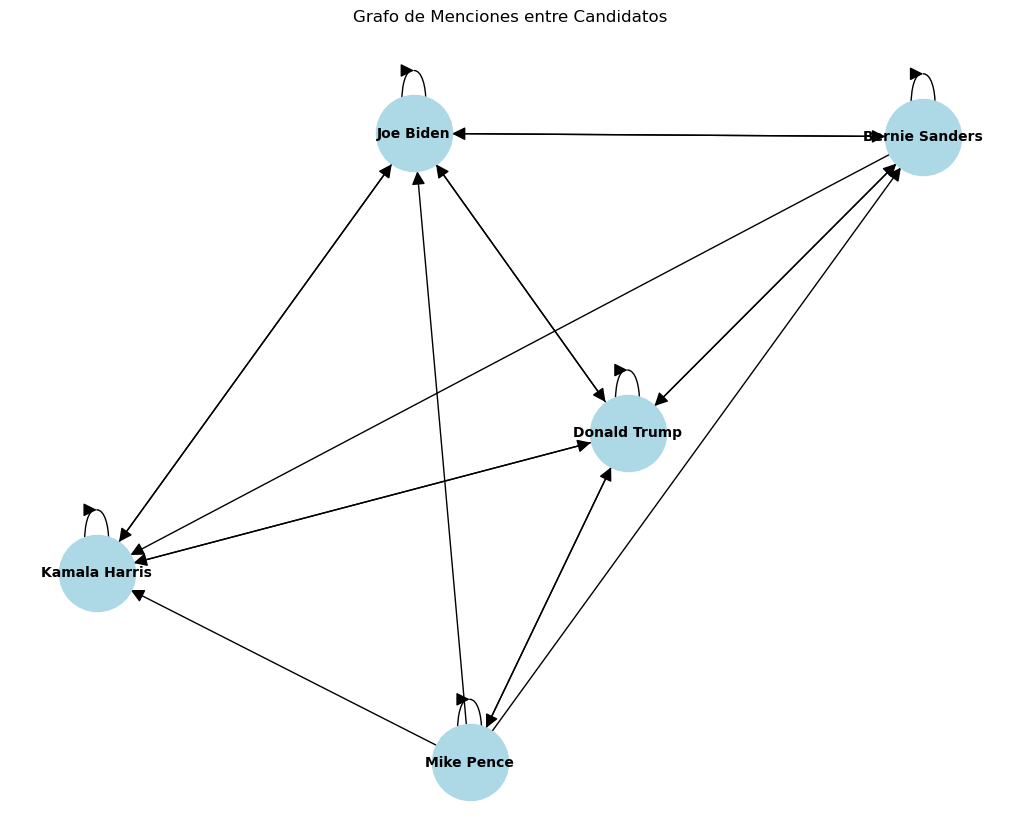

In [ ]:
candidates = top_speeches["speaker"].unique()
mentions_matrix = pd.DataFrame(0, index=candidates, columns=candidates)

# Menciones entre candidatos (sin contar a sí mismos) # FIX: si menciona a mas de uno se cuenta en cada candidato
for speaker in candidates:
    for mentioned in candidates:
        mentions_matrix.loc[speaker, mentioned] = top_speeches[
            (top_speeches["speaker"] == speaker) & 
            (top_speeches["CleanText"].str.contains(mentioned, case=False))
        ].shape[0]

# Visualizar la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(mentions_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Menciones entre Candidatos")
plt.xlabel("Mencionado")
plt.ylabel("Candidato")
plt.tight_layout()
plt.show()



In [ ]:
# Crear un grafo dirigido
G = nx.from_pandas_adjacency(mentions_matrix, create_using=nx.DiGraph)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("Grafo de Menciones entre Candidatos")
plt.show()